## Explanation Analysis Solar
This Notebook is designed to generate the explanations for the origins of uncertainty for the Solar data set

In [18]:
import numpy as np
import pandas as pd
import torch
import sys
import os

sys.path.append("..")
from models.gaussian_exog_no_temp_network import GaussianExogenousNoTemporalNetwork, \
    create_exogenous_no_temp_gaussian_predictions
from models.gaussian_small_exog_no_temp_network import GaussianSmallExogenousNoTemporalNetwork, \
    create_small_exogenous_no_temp_gaussian_predictions
from pipelines.preprocessing_pipeline import prep_data_exogenous, prep_data_small_exogenous
from metrics.evaluation_real_exogenous import create_stacked_explainations, create_prediction_plot, calculate_mean_stacked_explainations, plot_average_attribution_for_multiple_samples_solar, plot_mean_specific_time, plot_mean_specific_time_history
from metrics.crps import calculate_crps_gaussian
import tomlkit

In [19]:
df = pd.read_csv("../data/solar.csv", index_col="Unnamed: 0", parse_dates=True)
df.index.name = 'time'
df = df[['tclw', 'TCC', 'SSRD', 'POWER']]

In [20]:
with open('../configs/solar_config.toml', 'rb') as f:
    configs = tomlkit.load(f)

### Select Config and load models
The first step is to select the configuration we use and to load the appropriate models that have already been trained

In [21]:
# Select config to use
config = configs['Config1']

In [22]:
test_size = config['test_size']
number_of_features = config['number_of_features']
hidden_size_exogenous = config['hidden_size_exogenous']
hidden_size_exogenous_history = config['hidden_size_exogenous_history']
learning_rate = config['learning_rate']
hidden_size_no_temporal = config['hidden_size_no_temporal']
hidden_size_no_temporal_history = config['hidden_size_no_temporal_history']
num_epochs = config['num_epochs']
batch_size = config['batch_size']
save_path = config['save_path']
forecast_horizon = config['forecast_horizon']
history_length = config['history_length']
save_path_crps = f"{save_path}crps/"
save_exogenous_name = config['save_exogenous_name']
save_no_temporal_name = config['save_no_temporal_name']
descriptor = config['descriptor']
target_var = config['target_var']
feature1_var = config['feature1_var']
feature2_var = config['feature2_var']
feature3_var = config['feature3_var']

In [23]:
if number_of_features == 3:
    target_train, target_test, history_train, history_test, hour_cos_train, hour_cos_test, hour_sin_train, \
        hour_sin_test, day_cos_train, day_cos_test, day_sin_train, day_sin_test, month_cos_train, \
        month_cos_test, month_sin_train, month_sin_test, feature1_train, feature1_test, feature2_train, \
        feature2_test, feature3_train, feature3_test, target_scaler, history_scaler, feature1_scaler, \
        feature2_scaler, feature3_scaler = prep_data_exogenous(df=df,
                                                               target_var=target_var,
                                                               feature1_var=feature1_var,
                                                               feature2_var=feature2_var,
                                                               feature3_var=feature3_var,
                                                               history_length=history_length,
                                                               forecast_horizon=forecast_horizon,
                                                               test_size=test_size)

    model_no_temporal = GaussianExogenousNoTemporalNetwork(history_size=history_length,
                                                           feature_size=forecast_horizon,
                                                           hidden_size=hidden_size_no_temporal,
                                                           hidden_size_history=hidden_size_no_temporal_history,
                                                           output_size=forecast_horizon)
    model_no_temporal.load_state_dict(torch.load(f"../{save_path}models/{descriptor}_{save_no_temporal_name}"))
    mu_test_no_temporal, logvar_test_no_temporal = create_exogenous_no_temp_gaussian_predictions(
        model=model_no_temporal,
        history=history_test,
        feature1=feature1_test,
        feature2=feature2_test,
        feature3=feature3_test)
    crps_no_temporal = calculate_crps_gaussian(y_test=target_test,
                                               mu_test=mu_test_no_temporal,
                                               logvar_test=logvar_test_no_temporal)
else:
    target_train, target_test, history_train, history_test, hour_cos_train, hour_cos_test, hour_sin_train, \
        hour_sin_test, day_cos_train, day_cos_test, day_sin_train, day_sin_test, month_cos_train, \
        month_cos_test, month_sin_train, month_sin_test, feature1_train, feature1_test, feature2_train, \
        feature2_test, target_scaler, history_scaler, feature1_scaler, \
        feature2_scaler = prep_data_small_exogenous(df=df,
                                                    target_var=target_var,
                                                    feature1_var=feature1_var,
                                                    feature2_var=feature2_var,
                                                    history_length=history_length,
                                                    forecast_horizon=forecast_horizon,
                                                    test_size=test_size)

    model_no_temporal = GaussianSmallExogenousNoTemporalNetwork(history_size=history_length,
                                                                feature_size=forecast_horizon,
                                                                hidden_size=hidden_size_no_temporal,
                                                                hidden_size_history=hidden_size_no_temporal_history,
                                                                output_size=forecast_horizon)
    model_no_temporal.load_state_dict(torch.load(f"../{save_path}models/{descriptor}_{save_no_temporal_name}"))
    mu_test_no_temporal, logvar_test_no_temporal = create_small_exogenous_no_temp_gaussian_predictions(
        model=model_no_temporal,
        history=history_test,
        feature1=feature1_test,
        feature2=feature2_test)
    crps_no_temporal = calculate_crps_gaussian(y_test=target_test,
                                               mu_test=mu_test_no_temporal,
                                               logvar_test=logvar_test_no_temporal)

### Calculate CRPS and plot predictions
The next step is to calculate the CRPS and plot some prediction intervals

In [24]:
crps_no_temporal

0.12359448

In [26]:
plot_no_temporal = create_prediction_plot(start=168+13+12-24,
                                          num=2,
                                          fh=forecast_horizon,
                                          target=target_test,
                                          mu=mu_test_no_temporal,
                                          logvar=logvar_test_no_temporal,
                                          scaler=target_scaler,
                                          name=f"Figures/solar/PI{history_length}.tex")

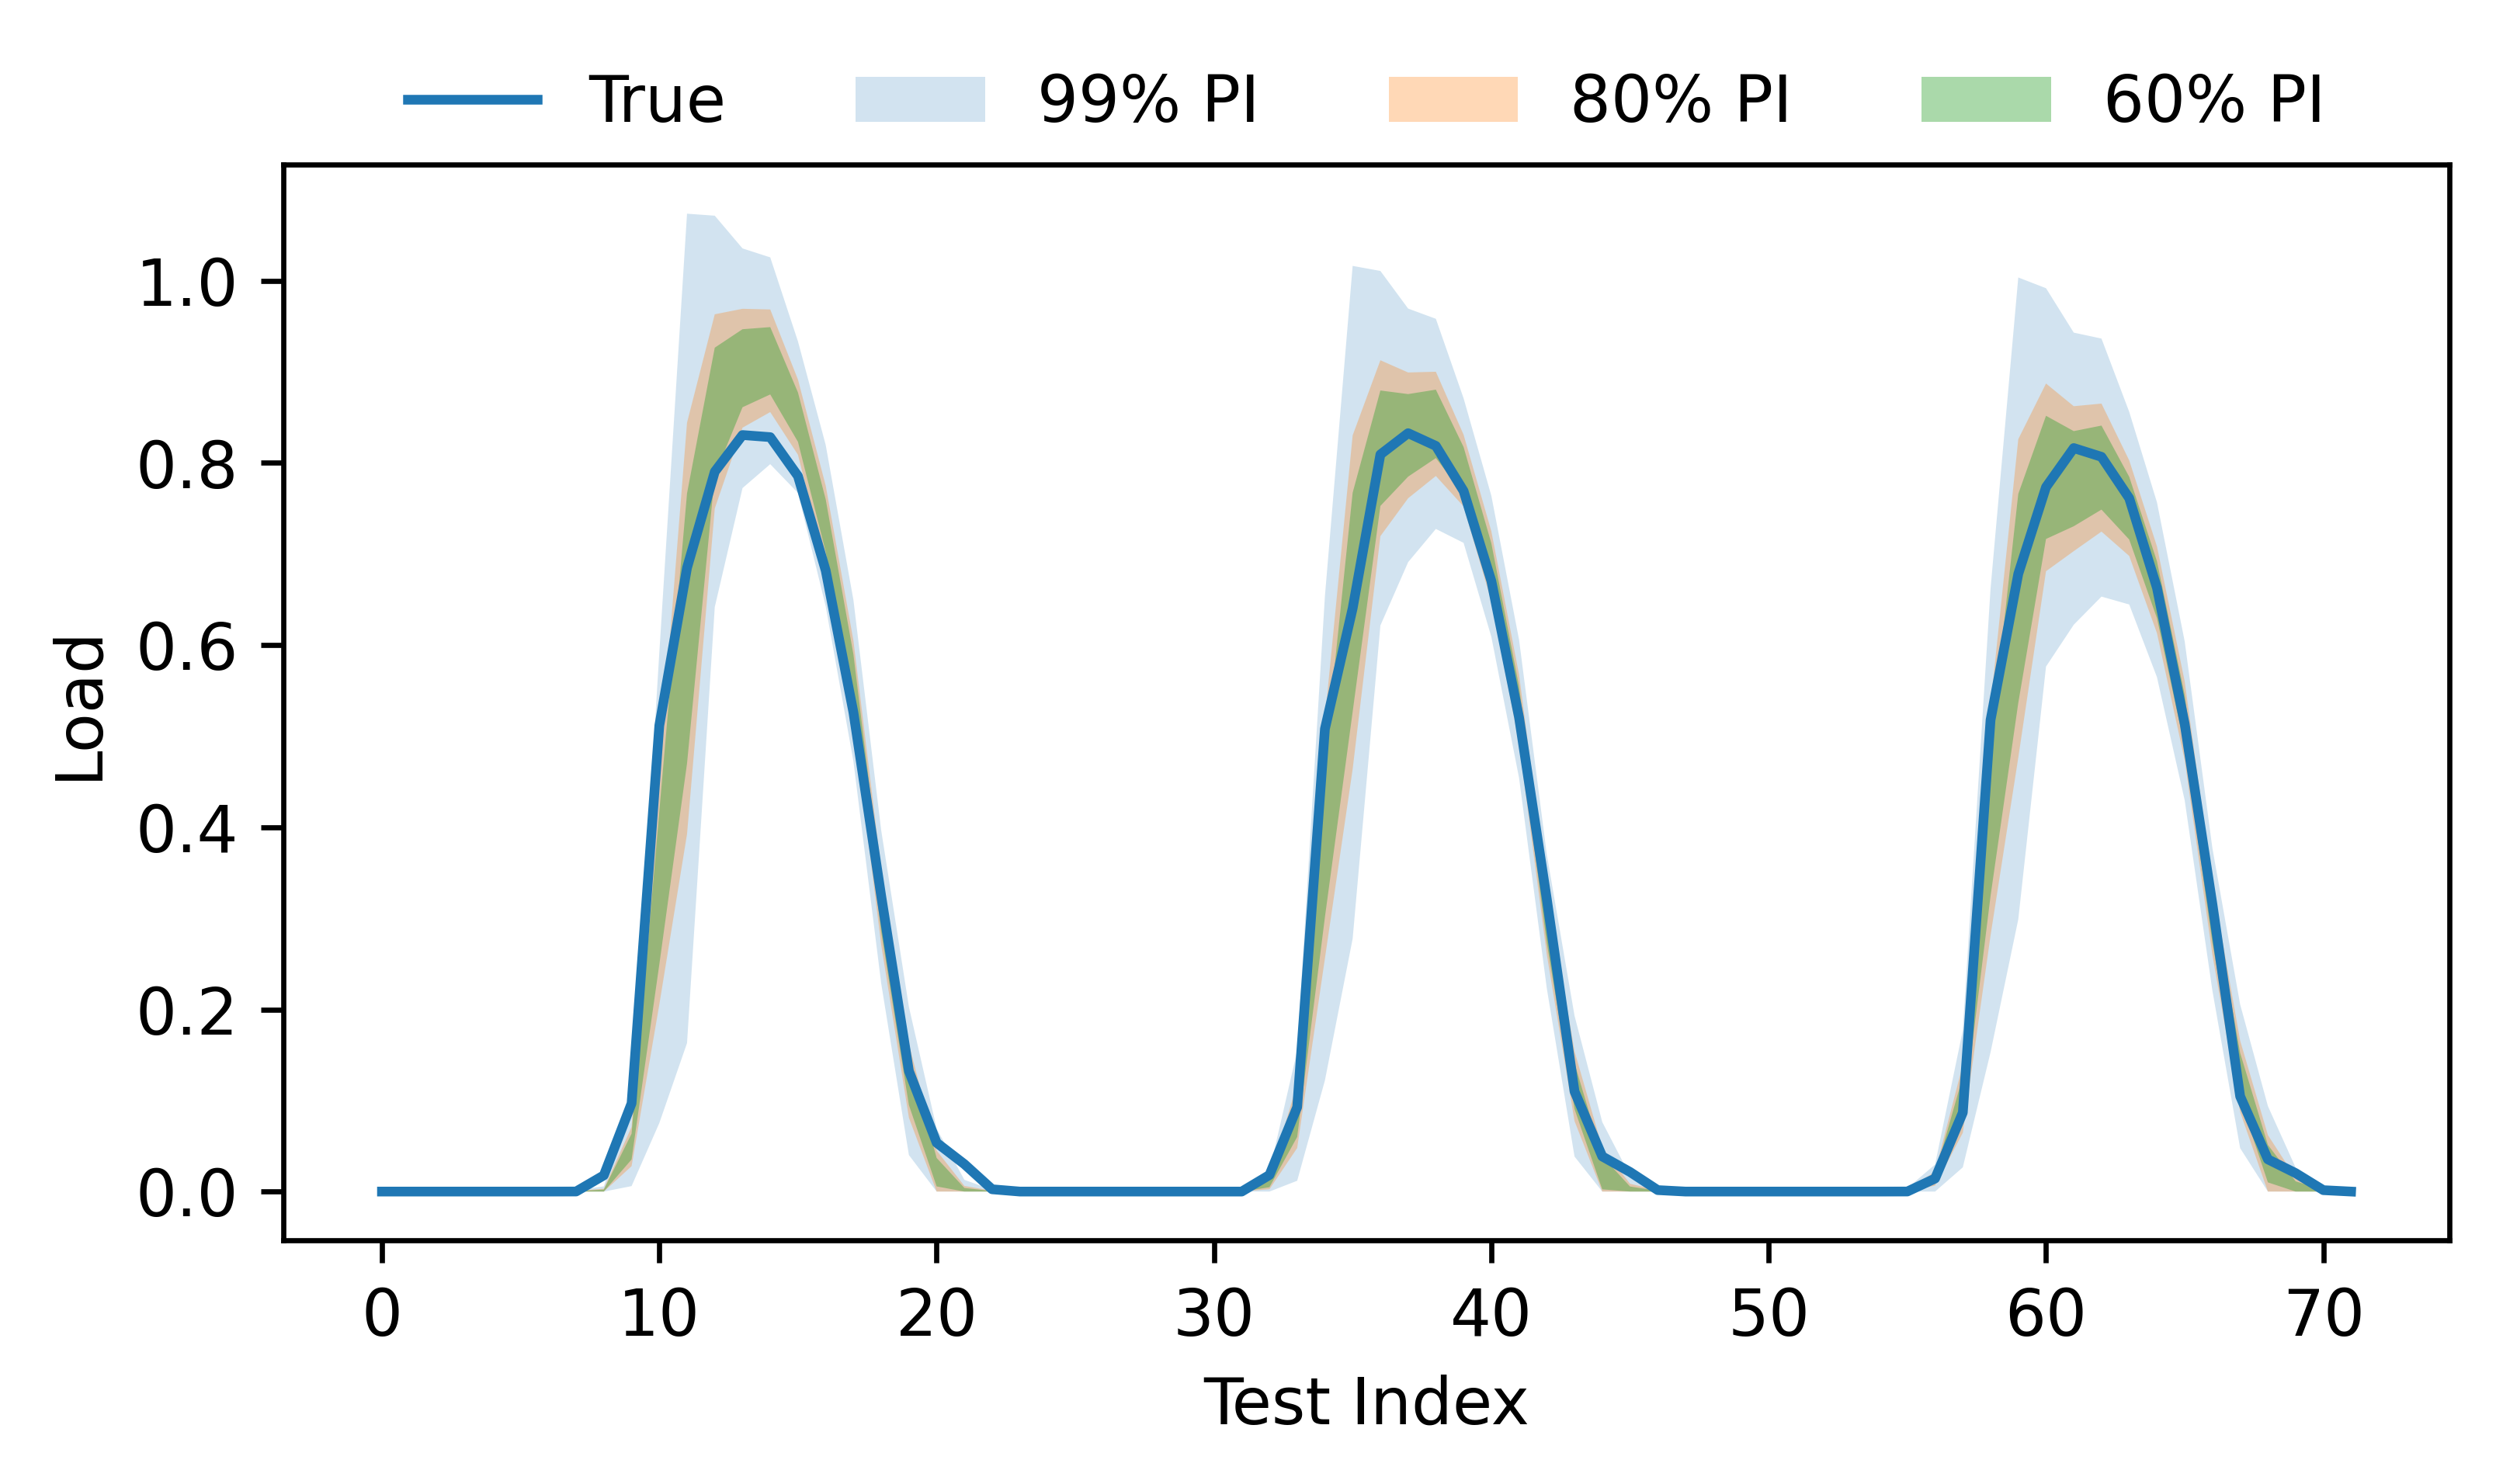

In [27]:
plot_no_temporal

## Create and Investigate Attributions
Now we create and investigate the attributions

In [28]:
day_offset = 13+12
considered_indexes = np.arange(0, len(history_test), 1)
#Consider daily patterns
the_step = 24
save_loc = "Figures/solar/"
isExist = os.path.exists(save_loc)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(save_loc)

In [ ]:
stacked_explain = create_stacked_explainations(model=model_no_temporal,
                                               indexes=considered_indexes,
                                               fh=forecast_horizon,
                                               history=history_test,
                                               feature1=feature1_test,
                                               feature2=feature2_test,
                                               feature3=feature3_test)

In [ ]:
his_dict = dict()
feature1_dict = dict()
feature2_dict = dict()
feature3_dict = dict()
for start_hour in [0, 7, 11, 18]:
    his_dict[start_hour] = plot_mean_specific_time_history(stacked_explainer_dict=stacked_explain,
                                                           indexes=considered_indexes,
                                                           step=the_step,
                                                           start=start_hour,
                                                           scaler=history_scaler,
                                                           fh=forecast_horizon,
                                                           hl=history_length,
                                                           history=history_test,
                                                           day_offset=day_offset)
    feature1_dict[start_hour] = plot_mean_specific_time(stacked_explainer_dict=stacked_explain,
                                                        indexes=considered_indexes,
                                                        step=the_step,
                                                        start=start_hour,
                                                        scaler=feature1_scaler,
                                                        fh=forecast_horizon,
                                                        feature=feature1_test,
                                                        feature_key="feature1",
                                                        day_offset=day_offset)
    feature2_dict[start_hour] = plot_mean_specific_time(stacked_explainer_dict=stacked_explain,
                                                        indexes=considered_indexes,
                                                        step=the_step,
                                                        start=start_hour,
                                                        scaler=feature2_scaler,
                                                        fh=forecast_horizon,
                                                        feature=feature2_test,
                                                        feature_key="feature2",
                                                        day_offset=day_offset)
    feature3_dict[start_hour] = plot_mean_specific_time(stacked_explainer_dict=stacked_explain,
                                                        indexes=considered_indexes,
                                                        step=the_step,
                                                        start=start_hour,
                                                        scaler=feature3_scaler,
                                                        fh=forecast_horizon,
                                                        feature=feature3_test,
                                                        feature_key="feature3",
                                                        day_offset=day_offset)

In [ ]:
mean_stacked = calculate_mean_stacked_explainations(model=model_no_temporal,
                                                    indexes=considered_indexes,
                                                    fh=forecast_horizon,
                                                    history=history_test,
                                                    feature1=feature1_test,
                                                    feature2=feature2_test,
                                                    feature3=feature3_test)

In [33]:
mean_average_mu = plot_average_attribution_for_multiple_samples_solar(stacked=mean_stacked,
                                                                      mean_or_logvar="mu",
                                                                      fh=forecast_horizon,
                                                                      day_offset=day_offset,
                                                                      end_point=100,
                                                                      vmax=0.4,
                                                                      vmin=0)
mean_average_logvar = plot_average_attribution_for_multiple_samples_solar(stacked=mean_stacked,
                                                                          mean_or_logvar="logvar",
                                                                          fh=forecast_horizon,
                                                                          day_offset=day_offset,
                                                                          end_point=100,
                                                                          vmax=0.8,
                                                                          vmin=0)

In [34]:
for start_hour in [0, 7, 11, 18]:
    his_dict[start_hour].savefig(f"{save_loc}{history_length}_start{start_hour}_mean_history.pdf", format="pdf", bbox_inches="tight")
    feature1_dict[start_hour].savefig(f"{save_loc}{history_length}_start{start_hour}_mean_tclw.pdf", format="pdf", bbox_inches="tight")
    feature2_dict[start_hour].savefig(f"{save_loc}{history_length}_start{start_hour}_mean_tcc.pdf", format="pdf", bbox_inches="tight")
    feature3_dict[start_hour].savefig(f"{save_loc}{history_length}_start{start_hour}_mean_ssrd.pdf", format="pdf", bbox_inches="tight")
mean_average_mu.savefig(f"{save_loc}{history_length}_mean_average_mu.pdf", format="pdf", bbox_inches="tight")
mean_average_logvar.savefig(f"{save_loc}{history_length}_mean_average_logvar.pdf", format="pdf", bbox_inches="tight")